In [128]:
from pynq import Overlay
from pynq import MMIO
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
ol = Overlay("./design_1_wrapper.bit") # designate a bitstream to be flashed to the FPGA

In [3]:
ol.download() # flash the FPGA

In [4]:
fir11_ip = MMIO(0x40000000, 0x10000) # (IP_BASE_ADDRESS, ADDRESS_RANGE), told to us in Vivado

In [5]:
inp = 100 # test input

In [6]:
fir11_ip.write(0x20, inp) # write input value to input address in fabric; 0x20 is x "data signal" according to fir_control_s_axi

In [7]:
# now I think if I read the output from Y, we should see first filtered value. I think the coefficients start with 53

In [8]:
# so y should read 530 because a 10 was written to x

In [9]:
print("x:", fir11_ip.read(0x20)) # check x

x: 100


In [10]:
fir11_ip.write(0x00, 1) # set ap_start to 1 which initiates the process - wait? Should this be a 0 to start?

In [11]:
print("y:", fir11_ip.read(0x10)) # read corresponding output value from the output address of the fabric

y: 5300


In [12]:
# holy crap it works

In [13]:
# now, I can either keep adding x values to understand it or work on getting python to IOstream our input.dat file...

In [56]:
inp = 97
fir11_ip.write(0x20, inp)
print("new x:", fir11_ip.read(0x20))
print("y check:",fir11_ip.read(0x10))
fir11_ip.write(0x00, 1)
out = fir11_ip.read(0x10)
if (out > 2147483648):
    out = out - (1 << 32)
print("new y:", out)

new x: 97
y check: 871
new y: 45541


In [29]:
print("new y:", int(fir11_ip.read(0x10)))

new y: 4294967190


In [32]:
int(-2)+(1 << 32)
4294967190 - (1 << 32) #practice conversion

-106

In [50]:
test = 4294967294
if (test > 2147483648):
    test = test - (1 << 32)
print(test)

-2


In [49]:
1 << 31

2147483648

In [17]:
# still looks good because next coeff is 0 ... , lets try again with -91 as next coeff. If 10 again , will be 530 - 910 = -380?

In [111]:
for i in range(11):
    inp = 0 # set x
    fir11_ip.write(0x20, inp) # feed x
    print("new x:", fir11_ip.read(0x20)) # check x
    fir11_ip.write(0x00, 1) # run filter
    print("new y:", fir11_ip.read(0x10)) # check y

new x: 0
new y: 0
new x: 0
new y: 0
new x: 0
new y: 0
new x: 0
new y: 0
new x: 0
new y: 0
new x: 0
new y: 0
new x: 0
new y: 0
new x: 0
new y: 0
new x: 0
new y: 0
new x: 0
new y: 0
new x: 0
new y: 0


In [110]:
# uh oh undefined behavior ?

In [40]:
# i see what's going on, we have a negative and we need a signed integer here

In [90]:
file = open("./input.dat","r")

In [91]:
print(file)

<_io.TextIOWrapper name='./input.dat' mode='r' encoding='UTF-8'>


In [92]:
read = file.readlines()
modified = []

In [93]:
for line in read:
    if line[-1] == '\n':
        modified.append(line[:-1])
    else:
        modified.append(line)
        
print(line)

-37


In [131]:
x_in = []
y_out = []
sample = []
count = 0
# run filter
for x in modified:
    sample.append(count)
    count = count+1
    inp = int(x) # set x
    print("x input: ", inp, end='\t')
    x_in.append(inp)
    fir11_ip.write(0x20, inp) # feed x
    fir11_ip.write(0x00, 1) # run filter
    y = fir11_ip.read(0x10)
    if (y > 2147483648):
        y = y - (1 << 32)
    print("filtered y:", y) # check y
    y_out.append(y)
    
# clear filter
for i in range(11):
    sample.append(count)
    count = count+1
    inp = 0 # set x
    fir11_ip.write(0x20, inp) # feed x
    print("x input: ", inp, end='\t')
    x_in.append(inp)
    fir11_ip.write(0x00, 1) # run filter
    y = fir11_ip.read(0x10)
    if (y > 2147483648):
        y = y - (1 << 32)
    print("filtered y:", y) # check y
    y_out.append(y)

x input:  100	filtered y: 5300
x input:  -2	filtered y: -106
x input:  -100	filtered y: -14400
x input:  13	filtered y: 871
x input:  97	filtered y: 45541
x input:  -36	filtered y: 46283
x input:  -86	filtered y: -14385
x input:  66	filtered y: -39783
x input:  59	filtered y: 7414
x input:  -93	filtered y: 30548
x input:  -10	filtered y: -6056
x input:  98	filtered y: -21242
x input:  -52	filtered y: 8576
x input:  -61	filtered y: 12863
x input:  97	filtered y: -8323
x input:  -17	filtered y: -6699
x input:  -81	filtered y: 6547
x input:  90	filtered y: 3859
x input:  -6	filtered y: -5325
x input:  -82	filtered y: -2297
x input:  92	filtered y: 6132
x input:  -21	filtered y: -557
x input:  -66	filtered y: -5684
x input:  100	filtered y: 5029
x input:  -59	filtered y: 1309
x input:  -22	filtered y: -5596
x input:  86	filtered y: 3818
x input:  -97	filtered y: 820
x input:  52	filtered y: -2885
x input:  18	filtered y: 2260
x input:  -77	filtered y: -480
x input:  100	filtered y: -798
x 

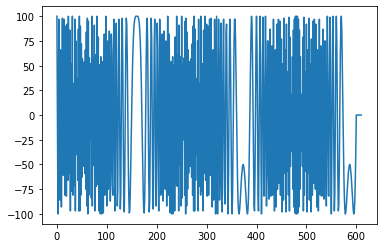

In [139]:
# Create a figure and axes object
fig, ax = plt.subplots()
ax.plot(sample,x_in)

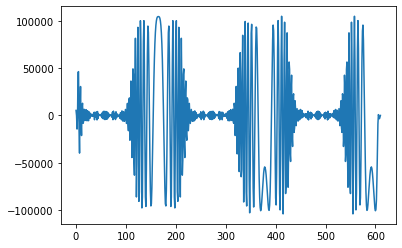

In [140]:
fig, ay = plt.subplots()
ay.plot(sample,y_out)